In [275]:
import pyqg
import pyqg_generative.tools.operators as op
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pyqg_parameterization_benchmarks.coarsening_ops as ppb
%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [207]:
def error(x,y):
    return float(np.mean(np.abs(x-y)))

In [208]:
X = np.random.randn(32,32)
Y = np.ones((32,32))
q = xr.open_dataset('/scratch/pp2681/pyqg_generative/highres/online_eddy.nc').isel(run=0,time=-1,lev=0).q.values.astype('float64')

ratio=2, error=0.11762837218566491
ratio=10, error=0.0023313807493607385
ratio=20, error=0.0009778420217614963
ratio=30, error=0.0006589856345277767


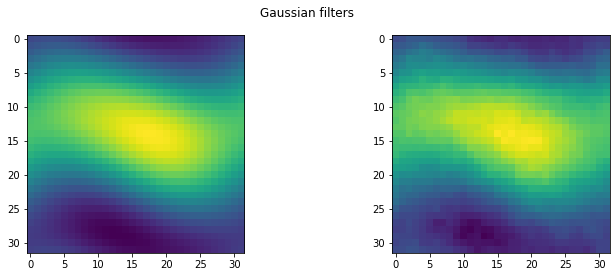

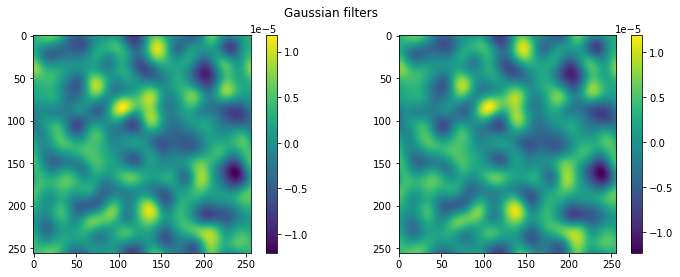

In [209]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.imshow(op.gauss_filter(X, 30))
plt.subplot(1,2,2); plt.imshow(op.gcm_filter(X, 30))
plt.suptitle('Gaussian filters')
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.imshow(op.gauss_filter(q, 30)); plt.colorbar()
plt.subplot(1,2,2); plt.imshow(op.gcm_filter(q, 30)); plt.colorbar()
plt.suptitle('Gaussian filters')

for ratio in [2, 10, 20, 30]:
    print(f'ratio={ratio}, error={error(op.gauss_filter(X, ratio), op.gcm_filter(X, ratio))}')

Text(0.5, 0.98, 'Model filter')

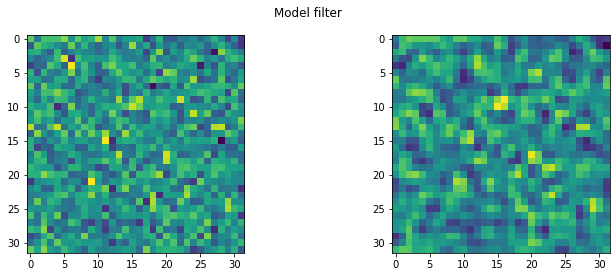

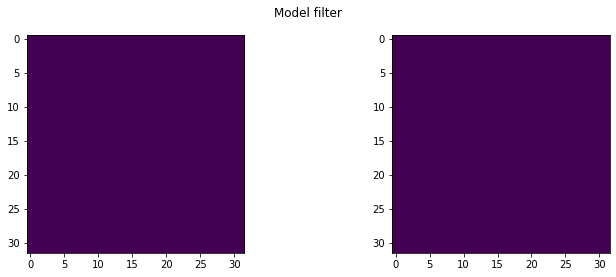

In [210]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.imshow(X)
plt.subplot(1,2,2); plt.imshow(op.model_filter(X))
plt.suptitle('Model filter')
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.imshow(Y)
plt.subplot(1,2,2); plt.imshow(op.model_filter(Y))
plt.suptitle('Model filter')

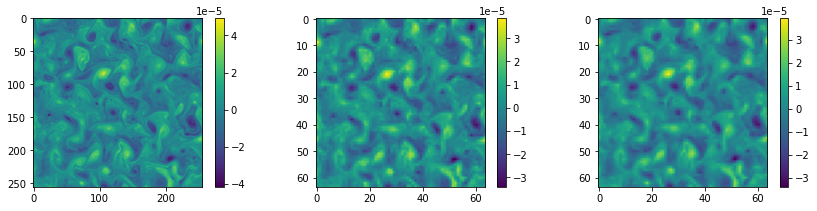

In [211]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.imshow(q); plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(op.cut_off(q,4)); plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(op.coarsegrain(q,4)); plt.colorbar()
plt.tight_layout()

# Commutation errors

In [212]:
error(op.gauss_filter(op.cut_off(X, 4), 2), op.cut_off(op.gauss_filter(X, 8), 4)) / np.mean(np.abs(X))

4.2663459013035894e-17

In [213]:
error(op.gcm_filter(op.coarsegrain(X, 4), 2), op.coarsegrain(op.gcm_filter(X, 8), 4)) / np.mean(np.abs(X))

0.0699565816574635

In [214]:
error(op.gcm_filter(op.gauss_filter(X, 3), 3), op.gauss_filter(op.gcm_filter(X, 3), 3)) / np.mean(np.abs(X))

8.986181819292345e-17

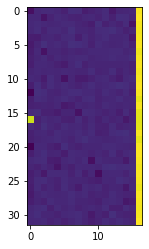

In [215]:
plt.imshow(np.log(np.abs(np.fft.rfftn(op.clean_2h(X)-X))))

# Try different formats

In [216]:
op1 = op.gauss_filter

In [217]:
op1(np.stack((X,X)), ratio=4)[0]

array([[-0.08186701,  0.36331508,  0.59135868, ..., -0.36586747,
        -0.54928997, -0.48427149],
       [-0.2140219 ,  0.17525374,  0.33233836, ..., -0.21777746,
        -0.48686691, -0.54269606],
       [-0.25812672, -0.10979735, -0.03845301, ...,  0.04078548,
        -0.15532784, -0.32672548],
       ...,
       [-0.17312307,  0.04086807,  0.270384  , ..., -0.11606866,
        -0.03262324, -0.12212379],
       [-0.09267739,  0.170159  ,  0.42749639, ..., -0.20052835,
        -0.12603912, -0.14181037],
       [ 0.02336076,  0.37472073,  0.60458348, ..., -0.29666483,
        -0.32255262, -0.24187058]])

In [218]:
ds = xr.open_dataset('/scratch/pp2681/pyqg_generative/highres/online_eddy.nc')

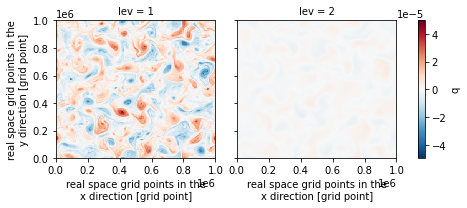

In [219]:
op.model_filter(ds.q.isel(run=0,time=-1), 2).plot(col='lev')


# Operators

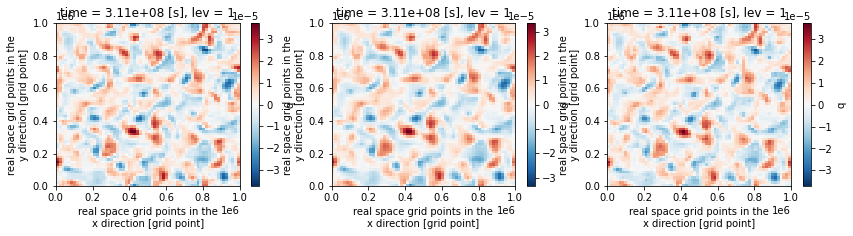

In [260]:
q = ds.q.isel(run=0, time=-1,lev=0)
plt.figure(figsize=(14,3))
plt.subplot(1,3,1)
op.Operator1(q, 4).plot()
plt.subplot(1,3,2)
op.Operator2(q, 4).plot()
plt.subplot(1,3,3)
op.Operator3(q, 4).plot()

# Comparison of operators to Andrew ones. Note the error only due to removing 2h harmonics!

In [305]:
m = pyqg.QGModel(nx=256, log_level=0)
q = ds.q.isel(run=0, time=-1).astype('float64')
m.q = q.values

In [306]:
def plot_operators(opAndrew, opMe):
    plt.figure(figsize=(14,3))
    plt.subplot(1,3,1)
    Andrew = opAndrew(m, 64).m2.q[0]
    plt.imshow(Andrew); plt.colorbar(); plt.title('Andrew')
    plt.subplot(1,3,2)
    Me = opMe(q, 4)[0]
    plt.imshow(Me); plt.colorbar(); plt.title('Me')
    plt.subplot(1,3,3)
    plt.imshow(np.abs(Andrew-Me)); plt.colorbar(); plt.title('Difference')
    plt.suptitle(opAndrew.__name__, y=1.05)

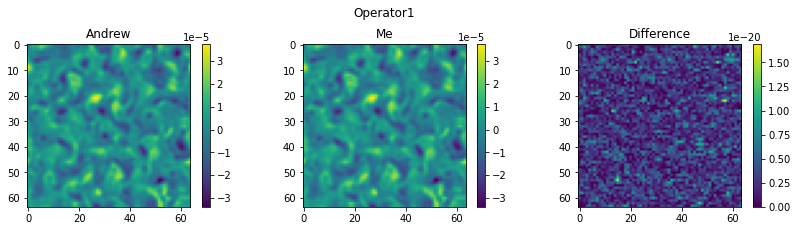

In [307]:
plot_operators(ppb.Operator1, op.Operator1)

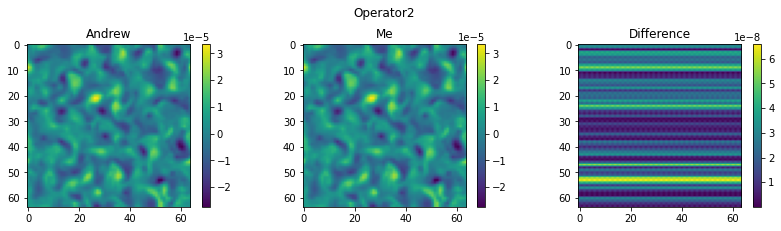

In [308]:
plot_operators(ppb.Operator2, op.Operator2)

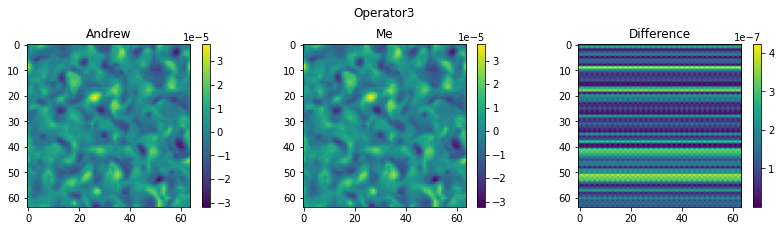

In [309]:
plot_operators(ppb.Operator3, op.Operator3)